## Model selection 

In this notebook we show how we compared three different models:
1. a random forest predictor
2. a gaussian process regressor
3. a Dense neural network

And ultimately went with the gaussian process regressor as our surrogate model

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import load_features_and_labels, load_property_data
from src.random_forest import train_rf_model
from src.gaussian_process import train_gp_model
from src.neural_network import train_nn_model

from rdkit.Chem import Draw
from rdkit import Chem

In [3]:
X, y = load_features_and_labels('./processed_data/initial_dataset/mordred_descriptors.csv',
                                './raw_data/photoswitches.csv',
                                'e_iso_pi')

In [9]:
rf_model, _, _ = train_rf_model(X, y)


Beginning training loop...

mean R^2: 0.8613 +- 0.0072
mean RMSE: 24.5489 +- 0.9114
mean MAE: 15.5711 +- 0.5936



In [10]:
gp_model, x_scaler, y_scaler = train_gp_model(X, y)


Beginning training loop...

mean R^2: 0.9045 +- 0.0080
mean RMSE: 20.1811 +- 0.8257
mean MAE: 12.8562 +- 0.4907



In [4]:
nn_model, _, _ = train_nn_model(X, y)


Beginning training loop...
Epoch 1/8
40/40 [==============================] - 4s 88ms/step - loss: 0.6554 - mae: 0.6554 - val_loss: 0.4015 - val_mae: 0.4015
Epoch 2/8
40/40 [==============================] - 4s 97ms/step - loss: 0.5845 - mae: 0.5845 - val_loss: 0.4995 - val_mae: 0.4995
Epoch 3/8
40/40 [==============================] - 5s 133ms/step - loss: 0.5581 - mae: 0.5581 - val_loss: 0.4369 - val_mae: 0.4369
Epoch 4/8
40/40 [==============================] - 5s 117ms/step - loss: 0.5165 - mae: 0.5165 - val_loss: 0.5164 - val_mae: 0.5164
Epoch 5/8
40/40 [==============================] - 4s 111ms/step - loss: 0.4436 - mae: 0.4436 - val_loss: 0.3510 - val_mae: 0.3510
Epoch 6/8
40/40 [==============================] - 4s 95ms/step - loss: 0.3208 - mae: 0.3208 - val_loss: 0.4733 - val_mae: 0.4733
Epoch 7/8
40/40 [==============================] - 3s 85ms/step - loss: 0.3390 - mae: 0.3390 - val_loss: 0.3043 - val_mae: 0.3043
Epoch 8/8
40/40 [==============================] - 5s 119ms

## Conclusions
As we can see the GPR model fitted the data the best, which is why from now on we will continue working with this model. It is worth mentioning that we also tried out other kernels(RBF, matern) for the GPR model, but they all performed far worse than the Tanimoto kernel did, which was used in the experiment here.

### We can also look at the output of the gaussian process regression model in order to determine maybe some structural features that correspond with uncertainty in the model

In [24]:
# first lets get all the smiles strings
df = pd.read_csv('./raw_data/photoswitches.csv')
smiles_list = df['SMILES'].to_numpy()
property_vals = load_property_data(df, 'e_iso_pi')
invalid_indices = np.argwhere(np.isnan(property_vals))
smiles_list = np.delete(np.array(smiles_list), invalid_indices)

# and now calculate the variance associated with all those molecules
y_vars = []
mean, vars = gp_model.predict_f(x_scaler.transform(X))
for var in vars:
  y_vars.append(var[0].numpy())
y_vars = np.array(y_vars)
  
# so that we an rank them in a list
ranked_confidence_list = np.argsort(y_vars, axis=0)

Most certain molecules: 

Variance: 
[0.00228205 0.00228205 0.00237557 0.00237557 0.00245205]


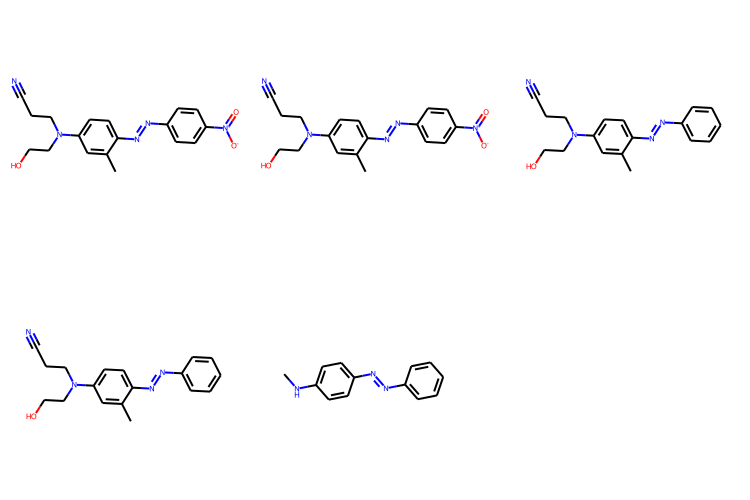

/n


In [27]:
print('Most certain molecules: \n')

search_idx = ranked_confidence_list[:5]
smiles = smiles_list[search_idx]

print('Variance: ')
print(y_vars[search_idx])

image = Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in smiles], subImgSize=(250,250))
display(image)

print('/n')

Least certain molecules: 

Certainty/variance: 
[0.24887145 0.25717914 0.26951871 0.27911134 0.29640113]


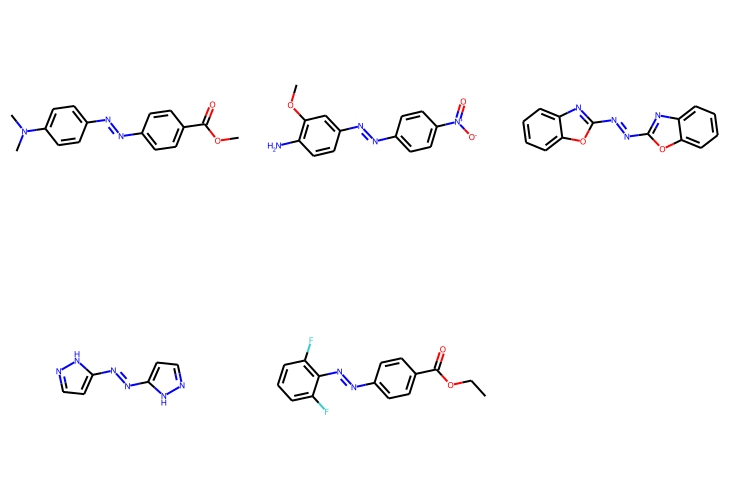

/n


In [29]:
print('Least certain molecules: \n')

search_idx = ranked_confidence_list[-5:]
smiles = smiles_list[search_idx]

print('Certainty/variance: ')
print(y_vars[search_idx])

image = Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in smiles], subImgSize=(250,250))
display(image)

print('/n')